# Creating dataset for Timeseries training (Multivariate)


https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
# for timezone()
import pytz
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def plot_series(time, series, format="-", start=0, end=None, interval=95):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """
    
    # Setup dimensions of the graph figure
    figure = plt.figure(figsize=(10, 6))
   
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))

    plt.gcf().autofmt_xdate()
    plt.show()

In [3]:
def getStockData(history_span, the_ticker):
  THE_URL = ('https://query1.finance.yahoo.com/v7/finance/'+
           'download/{ticker}?period1={period1}&period2={period2}&interval=1d&events=history&includeAdjustedClose=true')
  tdy = datetime.datetime.now(tz=pytz.timezone('Asia/Jakarta'))

  p2 = math.ceil(tdy.timestamp())
  p1 = math.floor((tdy - relativedelta(years=history_span)).timestamp())
  yf_url = THE_URL.format(ticker=the_ticker,period1=p1, period2=p2)
  df = pd.read_csv(yf_url)
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
  return df

In [ ]:
ticker_name = input('input ticker name:')
historical_span = int(input('input historical years:'))


In [5]:
df = getStockData(historical_span, ticker_name)

## Univariate normalization

In [6]:
df_close = df['Close']
ds_close = tf.convert_to_tensor(df_close)
print(df_close.shape)
print(ds_close.shape)
normalizer_univar = tf.keras.layers.Normalization(axis=None)
normalizer_univar.adapt(ds_close)
ds_close_normalized = normalizer_univar(ds_close)
print(ds_close_normalized.shape)

(735,)
(735,)
(735,)


In [7]:
print(tf.reduce_max(ds_close_normalized, axis=0).numpy())
print(tf.reduce_min(ds_close_normalized, axis=0).numpy())


2.021163
-1.9859109


In [8]:
df_open = df['Open']
ds_open = tf.convert_to_tensor(df_open)
print(df_open.shape)
print(ds_open.shape)
normalizer_univar = tf.keras.layers.Normalization(axis=None)
normalizer_univar.adapt(ds_open)
ds_open_normalized = normalizer_univar(ds_open)
print(ds_open_normalized.shape)

print(tf.reduce_max(ds_open_normalized, axis=0).numpy())
print(tf.reduce_min(ds_open_normalized, axis=0).numpy())

(735,)
(735,)
(735,)
2.1715477
-2.0158913


## Multivariate

In [9]:
df_01 = df[['Open', 'Close']]

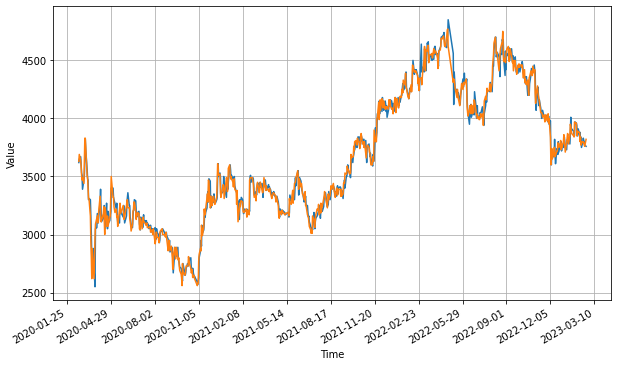

In [10]:
plot_series(df['Date'], df_01)

## Normalize

<class 'pandas.core.frame.DataFrame'>
(735, 2)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(735, 2)


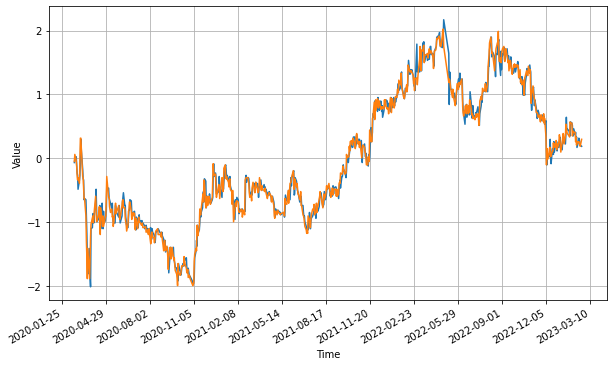

In [11]:
print(type(df_01))
print(df_01.shape)
normalizer = tf.keras.layers.Normalization(axis=None)
normalizer.adapt(df_01)
ds_01_normalized = normalizer(df_01)
print(type(ds_01_normalized))
print(ds_01_normalized.shape)
plot_series(df['Date'], ds_01_normalized)

(1, 735)


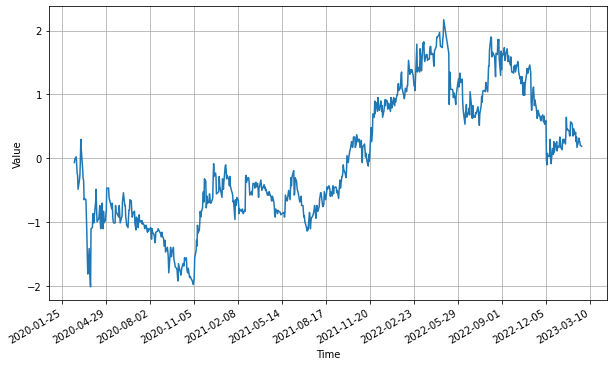

In [12]:
print(normalizer(df_01['Open']).shape)
plot_series(df['Date'], normalizer(df_01['Open'])[0])

(1, 735)


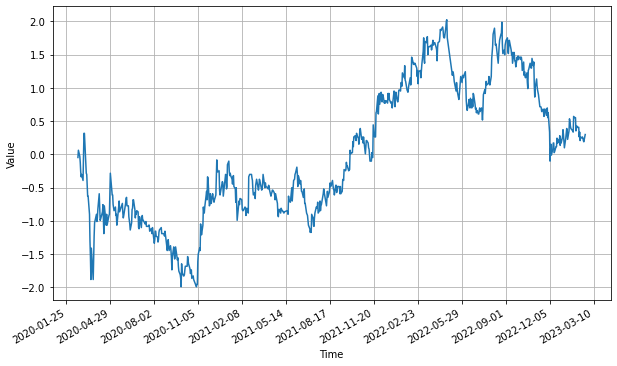

In [13]:
print(normalizer(df_01['Close']).shape)
plot_series(df['Date'], normalizer(df_01['Close'])[0])

In [14]:
print(ds_01_normalized.shape)

## since we have tensor with shape of (735, 2) we reduce (max) the 0 dimension (axis=0)
print(tf.reduce_max(ds_01_normalized, axis=0).numpy())
print(tf.reduce_min(ds_01_normalized, axis=0).numpy())


(735, 2)
[2.1688676 2.0235176]
[-2.0099468 -1.9917781]


In [15]:
print('Open max min:')
print(tf.reduce_max(normalizer(df_01['Open']), axis=1).numpy())
print(tf.reduce_min(normalizer(df_01['Open']), axis=1).numpy())
print()
print('Close max min:')
print(tf.reduce_max(normalizer(df_01['Close']), axis=1).numpy())
print(tf.reduce_min(normalizer(df_01['Close']), axis=1).numpy())


Open max min:
[2.1688676]
[-2.0099468]

Close max min:
[2.0235176]
[-1.9917781]


## Window dataset

In [16]:
df_01 = df[['Open', 'Close']]
print(df_01.head(n=12))
ds_01 = tf.convert_to_tensor(df_01)
print(type(ds_01))
print(ds_01.shape)

      Open   Close
0   3620.0  3630.0
1   3650.0  3690.0
2   3670.0  3640.0
3   3600.0  3590.0
4   3530.0  3510.0
5   3510.0  3470.0
6   3390.0  3490.0
7   3470.0  3440.0
8   3510.0  3620.0
9   3640.0  3830.0
10  3820.0  3830.0
11  3730.0  3750.0
<class 'tensorflow.python.framework.ops.EagerTensor'>
(735, 2)


In [17]:
# change to tensor slice ds
ds_01_sliced = tf.data.Dataset.from_tensor_slices(ds_01)
print(type(ds_01_sliced))

<class 'tensorflow.python.data.ops.from_tensor_slices_op.TensorSliceDataset'>


In [18]:
# Window the data but only take those with the specified size
ds_01_windowd = ds_01_sliced.window(5, shift=1, drop_remainder=True)

# Print the result
ii = 0
print('Windowed:')
print(type(ds_01_windowd))
for window_dataset in ds_01_windowd:
  print([item.numpy() for item in window_dataset])
  if(ii>5):
    break
  ii = ii+1

Windowed:
<class 'tensorflow.python.data.ops.dataset_ops.WindowDataset'>
[array([3620., 3630.]), array([3650., 3690.]), array([3670., 3640.]), array([3600., 3590.]), array([3530., 3510.])]
[array([3650., 3690.]), array([3670., 3640.]), array([3600., 3590.]), array([3530., 3510.]), array([3510., 3470.])]
[array([3670., 3640.]), array([3600., 3590.]), array([3530., 3510.]), array([3510., 3470.]), array([3390., 3490.])]
[array([3600., 3590.]), array([3530., 3510.]), array([3510., 3470.]), array([3390., 3490.]), array([3470., 3440.])]
[array([3530., 3510.]), array([3510., 3470.]), array([3390., 3490.]), array([3470., 3440.]), array([3510., 3620.])]
[array([3510., 3470.]), array([3390., 3490.]), array([3470., 3440.]), array([3510., 3620.]), array([3640., 3830.])]
[array([3390., 3490.]), array([3470., 3440.]), array([3510., 3620.]), array([3640., 3830.]), array([3820., 3830.])]


In [19]:
# Flatten the windows by putting its elements in a single batch
ds_01_windowd_flattened = ds_01_windowd.flat_map(lambda window: window.batch(5))
ii = 0
print()
print('Flat mapped:')
print(type(ds_01_windowd_flattened))
for window_dataset in ds_01_windowd_flattened:
  print([item.numpy() for item in window_dataset])
  if(ii>5):
    break
  ii = ii+1

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089



Flat mapped:
<class 'tensorflow.python.data.ops.dataset_ops.FlatMapDataset'>
[array([3620., 3630.]), array([3650., 3690.]), array([3670., 3640.]), array([3600., 3590.]), array([3530., 3510.])]
[array([3650., 3690.]), array([3670., 3640.]), array([3600., 3590.]), array([3530., 3510.]), array([3510., 3470.])]
[array([3670., 3640.]), array([3600., 3590.]), array([3530., 3510.]), array([3510., 3470.]), array([3390., 3490.])]
[array([3600., 3590.]), array([3530., 3510.]), array([3510., 3470.]), array([3390., 3490.]), array([3470., 3440.])]
[array([3530., 3510.]), array([3510., 3470.]), array([3390., 3490.]), array([3470., 3440.]), array([3510., 3620.])]
[array([3510., 3470.]), array([3390., 3490.]), array([3470., 3440.]), array([3510., 3620.]), array([3640., 3830.])]
[array([3390., 3490.]), array([3470., 3440.]), array([3510., 3620.]), array([3640., 3830.]), array([3820., 3830.])]


In [20]:
# Create tuples with features (first four elements of the window) and labels (last element)
ds_01_windowd_flattened_tuppled = ds_01_windowd_flattened.map(lambda window: (window[:-1], window[-1]))

ii = 0
print()
print('Labelled:')
print(type(ds_01_windowd_flattened_tuppled))
for window_dataset in ds_01_windowd_flattened_tuppled:
  print([item.numpy() for item in window_dataset])
  if(ii>5):
    break
  ii = ii+1


Labelled:
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
[array([[3620., 3630.],
       [3650., 3690.],
       [3670., 3640.],
       [3600., 3590.]]), array([3530., 3510.])]
[array([[3650., 3690.],
       [3670., 3640.],
       [3600., 3590.],
       [3530., 3510.]]), array([3510., 3470.])]
[array([[3670., 3640.],
       [3600., 3590.],
       [3530., 3510.],
       [3510., 3470.]]), array([3390., 3490.])]
[array([[3600., 3590.],
       [3530., 3510.],
       [3510., 3470.],
       [3390., 3490.]]), array([3470., 3440.])]
[array([[3530., 3510.],
       [3510., 3470.],
       [3390., 3490.],
       [3470., 3440.]]), array([3510., 3620.])]
[array([[3510., 3470.],
       [3390., 3490.],
       [3470., 3440.],
       [3510., 3620.]]), array([3640., 3830.])]
[array([[3390., 3490.],
       [3470., 3440.],
       [3510., 3620.],
       [3640., 3830.]]), array([3820., 3830.])]


In [21]:
# Create tuples with features (first four elements of the window) and labels (last element)
# but focusing only in Close as target
ds_01_windowd_flattened_tuppled_targetisclosed = ds_01_windowd_flattened.map(
    lambda window: (window[:-1], window[-1][1]))

ii = 0
print()
print('Labelled:')
print(type(ds_01_windowd_flattened_tuppled_targetisclosed))
for window_dataset in ds_01_windowd_flattened_tuppled_targetisclosed:
  print([item.numpy() for item in window_dataset])
  if(ii>5):
    break
  ii = ii+1


Labelled:
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
[array([[3620., 3630.],
       [3650., 3690.],
       [3670., 3640.],
       [3600., 3590.]]), 3510.0]
[array([[3650., 3690.],
       [3670., 3640.],
       [3600., 3590.],
       [3530., 3510.]]), 3470.0]
[array([[3670., 3640.],
       [3600., 3590.],
       [3530., 3510.],
       [3510., 3470.]]), 3490.0]
[array([[3600., 3590.],
       [3530., 3510.],
       [3510., 3470.],
       [3390., 3490.]]), 3440.0]
[array([[3530., 3510.],
       [3510., 3470.],
       [3390., 3490.],
       [3470., 3440.]]), 3620.0]
[array([[3510., 3470.],
       [3390., 3490.],
       [3470., 3440.],
       [3510., 3620.]]), 3830.0]
[array([[3390., 3490.],
       [3470., 3440.],
       [3510., 3620.],
       [3640., 3830.]]), 3830.0]


In [22]:
## skip shuffling and proceed to batching

# Create batches of windows
ds_close_windowd = ds_01_windowd_flattened_tuppled_targetisclosed.batch(7).prefetch(1)

# Print the results
ii = 0
print()
print('batched:')
print(type(ds_close_windowd))
for x,y in ds_close_windowd:
  print("x = ", x.numpy(), "({})".format(x.numpy().shape))
  print("y = ", y.numpy(), "({})".format(y.numpy().shape))
  print()
  if(ii>4):
    break
  ii = ii+1  


batched:
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
x =  [[[3620. 3630.]
  [3650. 3690.]
  [3670. 3640.]
  [3600. 3590.]]

 [[3650. 3690.]
  [3670. 3640.]
  [3600. 3590.]
  [3530. 3510.]]

 [[3670. 3640.]
  [3600. 3590.]
  [3530. 3510.]
  [3510. 3470.]]

 [[3600. 3590.]
  [3530. 3510.]
  [3510. 3470.]
  [3390. 3490.]]

 [[3530. 3510.]
  [3510. 3470.]
  [3390. 3490.]
  [3470. 3440.]]

 [[3510. 3470.]
  [3390. 3490.]
  [3470. 3440.]
  [3510. 3620.]]

 [[3390. 3490.]
  [3470. 3440.]
  [3510. 3620.]
  [3640. 3830.]]] ((7, 4, 2))
y =  [3510. 3470. 3490. 3440. 3620. 3830. 3830.] ((7,))

x =  [[[3470. 3440.]
  [3510. 3620.]
  [3640. 3830.]
  [3820. 3830.]]

 [[3510. 3620.]
  [3640. 3830.]
  [3820. 3830.]
  [3730. 3750.]]

 [[3640. 3830.]
  [3820. 3830.]
  [3730. 3750.]
  [3560. 3500.]]

 [[3820. 3830.]
  [3730. 3750.]
  [3560. 3500.]
  [3480. 3490.]]

 [[3730. 3750.]
  [3560. 3500.]
  [3480. 3490.]
  [3470. 3400.]]

 [[3560. 3500.]
  [3480. 3490.]
  [3470. 3400.]
  [330